In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./platesv2/"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'README.md', 'plates', 'sample_submission.csv']


In [2]:
data_root = './platesv2/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [3]:
import shutil 
from tqdm import tqdm

# Создаем папку "val_dir" для валидации
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# Перемещаем каждуй 6-ую фотографию в "val_dir" для валидации
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 1356.33it/s]


In [4]:
!ls train
!ls val

cleaned dirty
cleaned dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

# Применяем аугментации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Вырезаем участок изображения в виде прямоугольника и задаем ему размер 224
    transforms.RandomHorizontalFlip(), # Отзеркалим относительно горизонтали
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Применяем трансформации к изображениям, чтобы работать в удобном формате
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Сжимаем изображения до формата 224 на 224. 
    #224х224 - размер изображений ImageNet, на которых предобучен ResNet
    transforms.ToTensor(), # Преобразуем изображение в формат тензора PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Нормировка: хотим привести изображения к виду изображений,
    # на которых предобучался ResNet
])

# Итерируемся по изображениям и получаем пары: изображение - метка. 
# Метка - название директории, в которой хранится изображение
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

# Задаем батчи
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(5, 34)

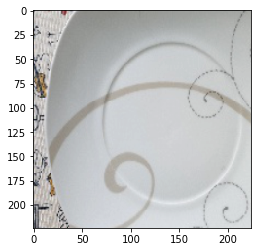

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

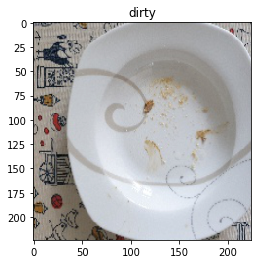

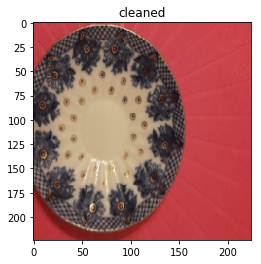

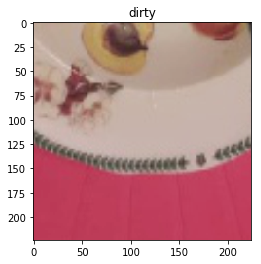

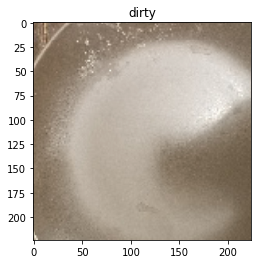

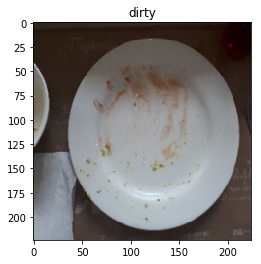

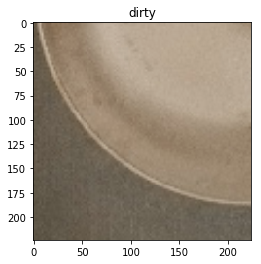

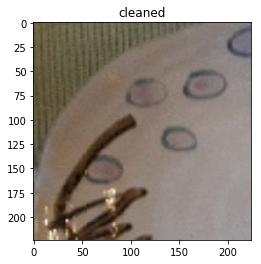

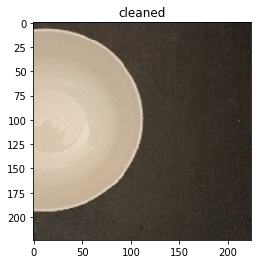

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/emintagiev/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [01:17<00:00, 607kB/s] 


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

train Loss: 0.7059 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

val Loss: 0.8572 Acc: 0.5000
Epoch 1/99:



100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

train Loss: 0.7035 Acc: 0.4750



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

val Loss: 0.8080 Acc: 0.3333
Epoch 2/99:



100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

train Loss: 0.6150 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

val Loss: 0.7638 Acc: 0.5000
Epoch 3/99:



100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

train Loss: 0.6006 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.7359 Acc: 0.5000
Epoch 4/99:



100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

train Loss: 0.5351 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

val Loss: 0.7259 Acc: 0.5000
Epoch 5/99:



100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

train Loss: 0.6064 Acc: 0.5250



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.7082 Acc: 0.5000
Epoch 6/99:



100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

train Loss: 0.5400 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

val Loss: 0.6847 Acc: 0.5000
Epoch 7/99:



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

train Loss: 0.5178 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.6947 Acc: 0.5000
Epoch 8/99:



100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

train Loss: 0.5089 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.7291 Acc: 0.5000
Epoch 9/99:



100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

train Loss: 0.5071 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

val Loss: 0.7213 Acc: 0.5000
Epoch 10/99:



100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

train Loss: 0.5161 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.7146 Acc: 0.5000
Epoch 11/99:



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

train Loss: 0.5880 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

val Loss: 0.7010 Acc: 0.5000
Epoch 12/99:



100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


KeyboardInterrupt: 

In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [14]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

 19%|█▉        | 18/93 [00:10<00:42,  1.78it/s]

KeyboardInterrupt: 

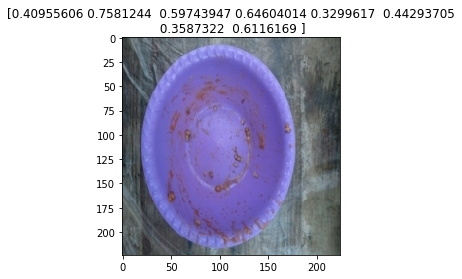

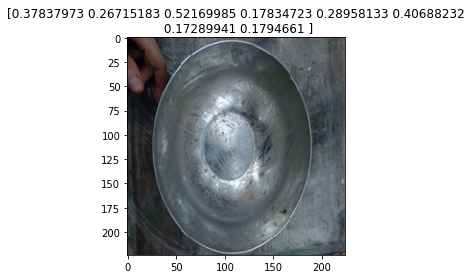

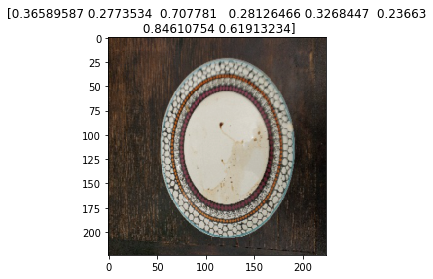

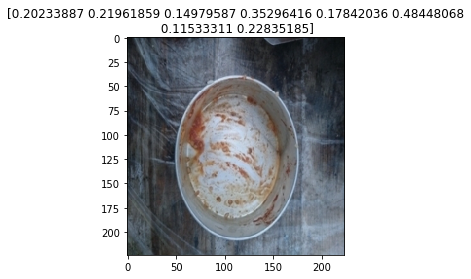

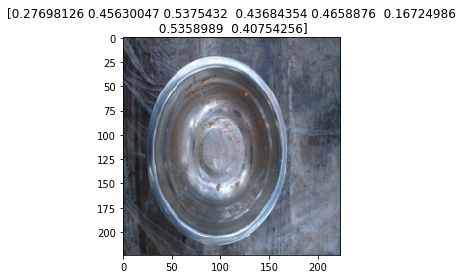

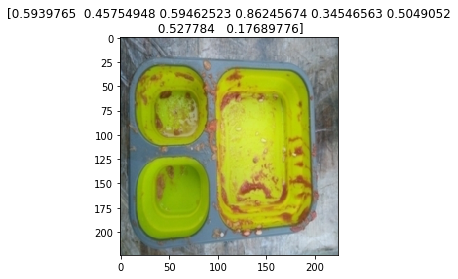

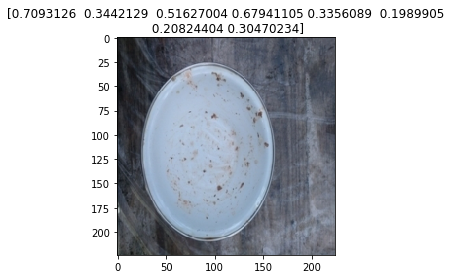

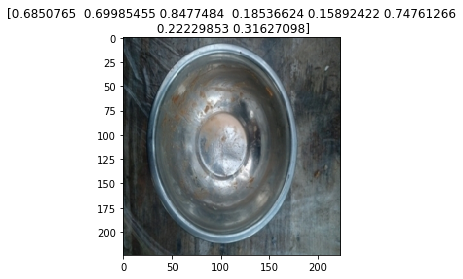

In [15]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [16]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

ValueError: arrays must all be same length

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test